# Battle of Neighborhoods

## 1 Introduction and business problem

###  Background
Where to start a business is a key important question to all the business owners. Different cities and areas are suitable for different business. The local economy, the cultures, the races of residents, all these can influence the decision. And there are no unique criteria for all industries or business to find the clue of decision-making. The factors which influence the decision-making vary from business to business. 

###  Business problem
Our client is a bottled sparkling water supplier, and they offer such water to the local restaurants. They have already a warehouse and delivery center in New York because of the diversified food restaurants and availability. And now they need to decide if Chicago is another good place to have a new center. The key importance for making decision in such business is availability of restaurants venues, and if Chicago is as diversified as New York in restaurant options, since the higher level of diverse, the higher level the acceptance of new brand the city has. 

### Target audience of this project
This project may be interested to the people who have the similar business, and they have not had any solution to make the final decision of which city should be the best to them to open a new beverage supply center. This project will also give some ideas to people who need to make the choice among the options.


## 2 Data acquisition and cleaning

###  Data sources and acquisition
The data for this project includes neighborhoods names and their coordinates, the venues names and their categories of each city. 

New York neighborhoods data source
https://cocl.us/new_york_dataset
Chicago neighborhoods data source
List of neighborhoods in Chicago - Wikipedia

To get the coordinates of the neighborhoods, geopy library of python language will be applied in this project. The coordinates which are the latitude and longitude of each neighborhood will be obtained with the help of geopy based on the neighborhoods names. 
Foursquare API can give us the access to the venue data which contains latitude, longitude and category. 
This project requires several skills for data acquisition, they are beautifulsoup for web scraping, requests and get for foursquare API, json for processing the downloaded json file. 

###  Data cleaning
The data of this project are from difference data sources with different format, including json, online table. All the data with different format need to be merged into one DataFrame format of Python. 
Since the coordinates of neighborhoods are obtained based on the neighborhoods names, so the coordinates are easily linked with neighborhoods. Venue data is extracted from Fousquare, and this dataset also contain the coordinates and the own neighborhood for each venue, so the venues dataset contains venues names, latitude, longitude, neighborhood and category. 
These two datasets can be merged by the overlap column, neighborhood name. 



In [1]:
!pip install folium

     |████████████████████████████████| 93 kB 4.1 MB/s  eta 0:00:01


In [2]:
# import the libs
import pandas as pd
import numpy as np
import json
from pandas.io.json import json_normalize 
from geopy import geocoders
import requests
from bs4 import BeautifulSoup
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import folium
import seaborn as sns
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim 

#### data collection

In [3]:
# get the data of NYC
!wget -q -O 'newyork_data.json' https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json
print('Data downloaded!')

Data downloaded!


In [4]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [5]:
neighborhoods_data = newyork_data['features']

In [6]:
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

In [7]:
# define the dataframe columns
column_names = ['Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
ny_neigh = pd.DataFrame(columns=column_names)

In [8]:
#neighborhoods
ny_neigh

,Neighborhood,Latitude,Longitude


In [9]:
for data in neighborhoods_data:
    #borough = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    ny_neigh = ny_neigh.append({#'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [10]:
ny_neigh.head()

,Neighborhood,Latitude,Longitude
0,Wakefield,40.894705,-73.847201
1,Co-op City,40.874294,-73.829939
2,Eastchester,40.887556,-73.827806
3,Fieldston,40.895437,-73.905643
4,Riverdale,40.890834,-73.912585


In [11]:
ny_neigh.shape

(306, 3)

In [12]:
# to get the coordinates of NYC


address = 'New York City, NY'
geolocator = Nominatim(user_agent = 'ny_explorer')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

print("The NYC latitude and longitude is {}, {} .".format(latitude,longitude))

The NYC latitude and longitude is 40.7127281, -74.0060152 .


In [18]:
# basic information for Foursquare API
CLIENT_ID = '5EMFCTTSBCPFMACYRQP5IEQUBUY4LUYDBDQSSHNPRAEBHCKO' # your Foursquare ID
CLIENT_SECRET = 'R4YECUULN5TUE3MEBOZYSPB0XXYQBXRMOBWTVALFGSZ1F4EA' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value
food_id = '4d4b7105d754a06374d81259' #venue category id for food

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 5EMFCTTSBCPFMACYRQP5IEQUBUY4LUYDBDQSSHNPRAEBHCKO
CLIENT_SECRET:R4YECUULN5TUE3MEBOZYSPB0XXYQBXRMOBWTVALFGSZ1F4EA


In [19]:
# function to get venues of all neighbors
# to create dataframe of venues in chicago by using Foursquare
def getNearByVenues(names, latitudes, longitudes, radius=1000):
    venues_list = []
    for name, lat,lng in zip(names, latitudes, longitudes):
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION, 
                lat, 
                lng, 
                radius, 
                LIMIT,
                food_id)
        # make the GET request
        results = requests.get(url).json()["response"]["groups"][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

ny_venues = getNearByVenues(names=ny_neigh['Neighborhood'], latitudes=ny_neigh['Latitude'], longitudes=ny_neigh['Longitude'])

In [51]:
ny_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Ripe Kitchen & Bar,40.898152,-73.838875,Caribbean Restaurant
1,Wakefield,40.894705,-73.847201,Ali's Roti Shop,40.894036,-73.856935,Caribbean Restaurant
2,Wakefield,40.894705,-73.847201,Jackie's West Indian Bakery,40.889283,-73.843310,Caribbean Restaurant
3,Wakefield,40.894705,-73.847201,Jimbo's,40.891740,-73.858226,Burger Joint
4,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop


### Chicago

In [52]:
chi_data = requests.get('https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Chicago').text
soup = BeautifulSoup(chi_data, 'lxml')

In [53]:
print(soup.title)

<title>List of neighborhoods in Chicago - Wikipedia</title>


In [54]:
chi_tab = str(soup.table)

In [55]:
from IPython.display import display_html

In [56]:
display_html(chi_tab, raw=True)

Neighborhood,Community area
Albany Park,Albany Park
Altgeld Gardens,Riverdale
Andersonville,Edgewater
Archer Heights,Archer Heights
Armour Square,Armour Square
Ashburn,Ashburn
Ashburn Estates,Ashburn
Auburn Gresham,Auburn Gresham
Avalon Park,Avalon Park
Avondale,Avondale


In [57]:
dfs = pd.read_html(chi_tab)
chi_neigh=dfs[0]
chi_neigh.head()

,Neighborhood,Community area
0,Albany Park,Albany Park
1,Altgeld Gardens,Riverdale
2,Andersonville,Edgewater
3,Archer Heights,Archer Heights
4,Armour Square,Armour Square


In [58]:
chi_neigh.shape

(246, 2)

In [59]:
chicago_neigh = chi_neigh.drop('Community area', axis=1)

In [60]:
chicago_neigh.head()

,Neighborhood
0,Albany Park
1,Altgeld Gardens
2,Andersonville
3,Archer Heights
4,Armour Square


In [61]:
chicago_neigh.tail()

,Neighborhood
241,Wildwood
242,Woodlawn
243,Wrightwood
244,Wrightwood Neighbors
245,Wrigleyville


In [62]:
chicago_neigh['Latitude'] = ''
chicago_neigh['Longitude'] = ''
chicago_neigh['Location'] = ''

In [63]:
for n, neigh in zip(range(0, len(chicago_neigh['Neighborhood'])), chicago_neigh['Neighborhood']):
    address = '{}, Chicago, Illinois'.format(chicago_neigh['Neighborhood'][n])
    try:
        geolocator = Nominatim(user_agent='chi_exploere')
        location = geolocator.geocode(address)
        chicago_neigh.loc[n,'Location'] = str(location)
        chicago_neigh.loc[n, 'Latitude'] = location.latitude
        chicago_neigh.loc[n, 'Longitude'] = location.longitude
    except AttributeError:
        continue

chicago_neigh.head()

,Neighborhood,Latitude,Longitude,Location
0,Albany Park,41.9719,-87.7162,"Albany Park, Chicago, Jefferson Township, Cook..."
1,Altgeld Gardens,41.6553,-87.6096,"Altgeld Gardens, Chicago, Hyde Park Township, ..."
2,Andersonville,41.9771,-87.6693,"Andersonville Park, 5233, Edgewater, Chicago, ..."
3,Archer Heights,41.8114,-87.7262,"Archer Heights, Chicago, Lake Township, Cook C..."
4,Armour Square,41.8402,-87.633,"Armour Square, Chicago, Cook County, Illinois,..."


In [64]:
# to make sure each line has 'chicago' within its location
chicago_neigh = chicago_neigh[chicago_neigh['Location'].str.contains('Chicago')]
chicago_neigh.reset_index(drop=True, inplace=True)
chicago_neigh.drop('Location', axis=1, inplace=True)
chicago_neigh.head()

,Neighborhood,Latitude,Longitude
0,Albany Park,41.9719,-87.7162
1,Altgeld Gardens,41.6553,-87.6096
2,Andersonville,41.9771,-87.6693
3,Archer Heights,41.8114,-87.7262
4,Armour Square,41.8402,-87.633


In [65]:
print('We have {} neighborhoods in our dataset of Chicago. '.format(chicago_neigh.shape[0]))

We have 232 neighborhoods in our dataset of Chicago. 


In [66]:
# to get the venues by using Foursquare API
chicago_venues = getNearByVenues(names=chicago_neigh['Neighborhood'], latitudes=chicago_neigh['Latitude'], longitudes=chicago_neigh['Longitude'])

In [67]:
chicago_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Albany Park,41.971937,-87.716174,Tre Kronor,41.975842,-87.711037,Scandinavian Restaurant
1,Albany Park,41.971937,-87.716174,Great Sea Chinese Restaurant,41.968496,-87.710678,Chinese Restaurant
2,Albany Park,41.971937,-87.716174,Merla's Kitchen,41.976063,-87.713559,Restaurant
3,Albany Park,41.971937,-87.716174,Peking Mandarin Resturant,41.968292,-87.715783,Chinese Restaurant
4,Albany Park,41.971937,-87.716174,2 Asian Brothers,41.975832,-87.709655,Vietnamese Restaurant


In [68]:
print('Chicago has {} unique categories.'.format(len(chicago_venues['Venue Category'].unique())))

Chicago has 111 unique categories.


In [34]:
chicago_venues.groupby('Neighborhood').count().head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Albany Park,57,57,57,57,57,57
Altgeld Gardens,3,3,3,3,3,3
Andersonville,100,100,100,100,100,100
Archer Heights,23,23,23,23,23,23
Armour Square,44,44,44,44,44,44


### visualization

In [69]:
ny_address = 'New York City, NY'
geolocator = Nominatim(user_agent='ny_explorer')
ny_location = geolocator.geocode(ny_address)
ny_latitude = ny_location.latitude
ny_longitude = ny_location.longitude

In [70]:
# to create a map for NY
map_ny = folium.Map(location=[ny_latitude, ny_longitude], zoom_start=10)

# to add markers
for lat, lng, label in zip(ny_neigh['Latitude'], ny_neigh['Longitude'], ny_neigh['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
    [lat, lng],
    radius=5,
    popup=label,
    color='blue',
    fill = True,
    fill_color='#3186cc',
    fill_opacity=0.7,
    parse_html=False).add_to(map_ny)

map_ny

### Chicago

In [71]:
address = 'Chicago, Illinois, USA'
geolocator = Nominatim(user_agent='chi_explorer')
chicago_location = geolocator.geocode(address)
chicago_latitude = chicago_location.latitude
chicago_longitude = chicago_location.longitude

In [72]:
map_chicago = folium.Map(location = [chicago_latitude,chicago_longitude], zoom_start=10)

for lat, lng, label in zip(chicago_neigh['Latitude'], chicago_neigh['Longitude'], chicago_neigh['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
    [lat, lng],
    radius=5,
    popup=label,
    color='red',
    fill = True,
    fill_color='#3186cc',
    fill_opacity=0.7,
    parse_html=False).add_to(map_chicago)

map_chicago

## Data Processing and Transformation

In [73]:
# one hot encoding
ny_onehot = pd.get_dummies(ny_venues[['Venue Category']], prefix_sep="")
chicago_onehot = pd.get_dummies(chicago_venues[['Venue Category']], prefix_sep="")

ny_onehot

,Venue CategoryAfghan Restaurant,Venue CategoryAfrican Restaurant,Venue CategoryAmerican Restaurant,Venue CategoryArepa Restaurant,Venue CategoryArgentinian Restaurant,Venue CategoryAsian Restaurant,Venue CategoryAustralian Restaurant,Venue CategoryAustrian Restaurant,Venue CategoryBBQ Joint,Venue CategoryBagel Shop,...,Venue CategoryTibetan Restaurant,Venue CategoryTonkatsu Restaurant,Venue CategoryTurkish Restaurant,Venue CategoryUdon Restaurant,Venue CategoryUkrainian Restaurant,Venue CategoryVarenyky restaurant,Venue CategoryVegetarian / Vegan Restaurant,Venue CategoryVenezuelan Restaurant,Venue CategoryVietnamese Restaurant,Venue CategoryWings Joint
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17741,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17742,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17743,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17744,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [74]:
ny_onehot['Neighborhood'] = ny_venues['Neighborhood']
chicago_onehot['Neighborhood'] = chicago_venues['Neighborhood']

# to move neighborhood column to the first column
ny_onehot = ny_onehot[[ny_onehot.columns[-1]] + list(ny_onehot.columns[:-1])]
chicago_onehot = chicago_onehot[[chicago_onehot.columns[-1]] + list(chicago_onehot.columns[:-1])]

# to group the rows by neighborhood and by mean of the frequency of occurence of each category
ny_grouped = ny_onehot.groupby('Neighborhood').mean().reset_index()
chicago_grouped = chicago_onehot.groupby('Neighborhood').mean().reset_index()

In [75]:
ny_grouped.head()

,Neighborhood,Venue CategoryAfghan Restaurant,Venue CategoryAfrican Restaurant,Venue CategoryAmerican Restaurant,Venue CategoryArepa Restaurant,Venue CategoryArgentinian Restaurant,Venue CategoryAsian Restaurant,Venue CategoryAustralian Restaurant,Venue CategoryAustrian Restaurant,Venue CategoryBBQ Joint,...,Venue CategoryTibetan Restaurant,Venue CategoryTonkatsu Restaurant,Venue CategoryTurkish Restaurant,Venue CategoryUdon Restaurant,Venue CategoryUkrainian Restaurant,Venue CategoryVarenyky restaurant,Venue CategoryVegetarian / Vegan Restaurant,Venue CategoryVenezuelan Restaurant,Venue CategoryVietnamese Restaurant,Venue CategoryWings Joint
0,Allerton,0.0,0.0,0.030303,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Annadale,0.0,0.0,0.176471,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Arden Heights,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Arlington,0.0,0.0,0.100000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1
4,Arrochar,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [76]:
chicago_grouped.head()

,Neighborhood,Venue CategoryAfghan Restaurant,Venue CategoryAfrican Restaurant,Venue CategoryAmerican Restaurant,Venue CategoryArepa Restaurant,Venue CategoryArgentinian Restaurant,Venue CategoryAsian Restaurant,Venue CategoryBBQ Joint,Venue CategoryBagel Shop,Venue CategoryBakery,...,Venue CategoryTapas Restaurant,Venue CategoryTex-Mex Restaurant,Venue CategoryThai Restaurant,Venue CategoryTheme Restaurant,Venue CategoryTurkish Restaurant,Venue CategoryUkrainian Restaurant,Venue CategoryVegetarian / Vegan Restaurant,Venue CategoryVenezuelan Restaurant,Venue CategoryVietnamese Restaurant,Venue CategoryWings Joint
0,Albany Park,0.0,0.0,0.000000,0.0,0.0,0.052632,0.0,0.000000,0.035088,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.035088,0.000000
1,Altgeld Gardens,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
2,Andersonville,0.0,0.0,0.030000,0.0,0.0,0.040000,0.0,0.000000,0.050000,...,0.0,0.0,0.04,0.0,0.0,0.0,0.0,0.0,0.110000,0.000000
3,Archer Heights,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.041667,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.041667
4,Armour Square,0.0,0.0,0.088889,0.0,0.0,0.066667,0.0,0.022222,0.066667,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000


In [77]:
# to make the descending order for the dataset
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [78]:
def get_df_name(df):
    name = [x for x in globals() if globals()[x] is df][0]
    return name.split('_',1)[0]

In [79]:
# let's create the new dataframe and display the top 10 venues for each neighborhood
num_top_venue = 10
indicators = ['st','nd','rd']

# to create a function to get the sorted datasets
def top_venues(dataset):
    
    # create columns according to number of top venues
    columns = ['Neighborhood']
    for ind in np.arange(num_top_venue):
        try:
            columns.append('{}{ } Most Common Venue'.format(ind+1, indicators[ind]))
        except:
            columns.append('{}the Most Common Venue'.format(ind+1))
    
    # to create a new dataframe
    neigh_sorted = pd.DataFrame(columns=columns)
    neigh_sorted['Neighborhood'] = dataset['Neighborhood']
    
    for ind in np.arange(dataset.shape[0]):
        neigh_sorted.iloc[ind, 1:] = return_most_common_venues(dataset.iloc[ind,:], num_top_venue)
    return neigh_sorted

In [80]:
# to get sorted venues for each city
ny_sorted = top_venues(ny_grouped)
chicago_sorted = top_venues(chicago_grouped)

## Clustering Analysis

In [81]:
!pip install yellowbrick 

     |████████████████████████████████| 269 kB 11.2 MB/s eta 0:00:01


In [82]:
from yellowbrick.cluster import KElbowVisualizer

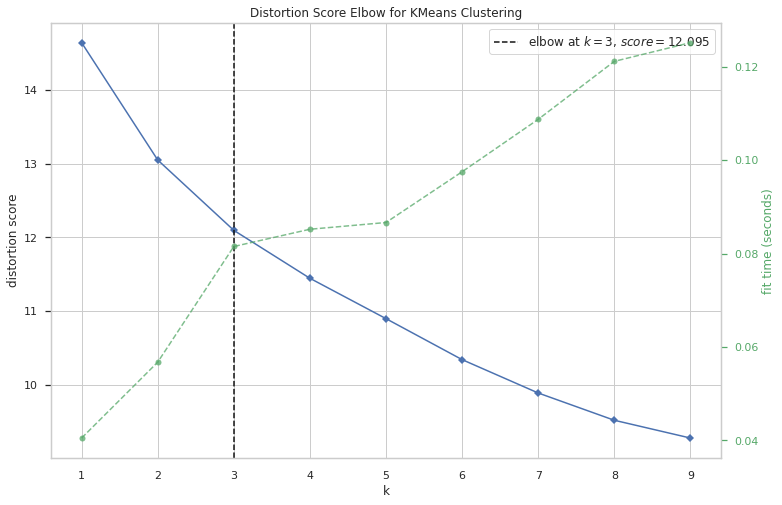

In [110]:
ny_grouped_cluster = ny_grouped.drop('Neighborhood', axis=1)
ny_model = KMeans(random_state=1)
plt.figure(figsize=(12,8))
visualizer = KElbowVisualizer(ny_model, k=(1,10)).fit(ny_grouped_cluster).show()

In [84]:
# clustering analysis
k_ny = 4
ny_kmeans = KMeans(n_clusters=k_ny, random_state=1).fit(ny_grouped_cluster)
ny_kmeans.labels_[0:10]

array([2, 3, 1, 2, 2, 2, 1, 2, 1, 3], dtype=int32)

In [85]:
ny_sorted.insert(0,'Label', ny_kmeans.labels_)
ny_merged = ny_neigh
ny_merged = ny_merged.join(ny_sorted.set_index('Neighborhood'), on='Neighborhood')
ny_merged.head()

,Neighborhood,Latitude,Longitude,Label,1the Most Common Venue,2the Most Common Venue,3the Most Common Venue,4the Most Common Venue,5the Most Common Venue,6the Most Common Venue,7the Most Common Venue,8the Most Common Venue,9the Most Common Venue,10the Most Common Venue
0,Wakefield,40.894705,-73.847201,2,Venue CategoryDeli / Bodega,Venue CategoryFast Food Restaurant,Venue CategoryCaribbean Restaurant,Venue CategoryFood,Venue CategoryPizza Place,Venue CategoryChinese Restaurant,Venue CategoryDonut Shop,Venue CategoryFried Chicken Joint,Venue CategoryAsian Restaurant,Venue CategoryBakery
1,Co-op City,40.874294,-73.829939,2,Venue CategoryDeli / Bodega,Venue CategoryPizza Place,Venue CategoryFast Food Restaurant,Venue CategoryChinese Restaurant,Venue CategoryBakery,Venue CategoryRestaurant,Venue CategoryDonut Shop,Venue CategoryCaribbean Restaurant,Venue CategoryBBQ Joint,Venue CategoryMexican Restaurant
2,Eastchester,40.887556,-73.827806,2,Venue CategoryPizza Place,Venue CategoryCaribbean Restaurant,Venue CategoryDeli / Bodega,Venue CategoryFast Food Restaurant,Venue CategoryDiner,Venue CategoryChinese Restaurant,Venue CategoryDonut Shop,Venue CategoryAsian Restaurant,Venue CategorySandwich Place,Venue CategoryBakery
3,Fieldston,40.895437,-73.905643,2,Venue CategoryDeli / Bodega,Venue CategoryPizza Place,Venue CategoryMexican Restaurant,Venue CategorySandwich Place,Venue CategoryChinese Restaurant,Venue CategoryTapas Restaurant,Venue CategoryDonut Shop,Venue CategoryDiner,Venue CategoryFast Food Restaurant,Venue CategoryBurger Joint
4,Riverdale,40.890834,-73.912585,1,Venue CategoryItalian Restaurant,Venue CategoryPizza Place,Venue CategoryMexican Restaurant,Venue CategoryDeli / Bodega,Venue CategoryJapanese Restaurant,Venue CategoryBagel Shop,Venue CategoryDiner,Venue CategorySandwich Place,Venue CategoryGreek Restaurant,Venue CategoryKorean Restaurant


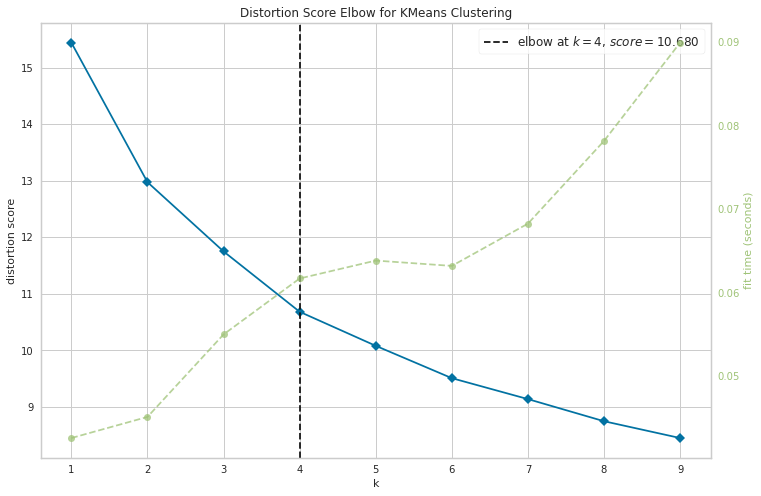

In [86]:
chicago_grouped_cluster = chicago_grouped.drop('Neighborhood', axis=1)
chicago_model = KMeans(random_state=1)
plt.figure(figsize=(12,8))
visualizer = KElbowVisualizer(chicago_model, k=(1,10)).fit(chicago_grouped_cluster).show()

In [87]:
k_chicago = 4
chicago_kmeans = KMeans(n_clusters=k_chicago, random_state=1).fit(chicago_grouped_cluster)
chicago_kmeans.labels_[0:10]

array([0, 2, 0, 1, 0, 3, 3, 3, 0, 0], dtype=int32)

In [88]:
chicago_sorted.insert(0,'Label', chicago_kmeans.labels_)
chicago_merged = chicago_neigh
chicago_merged = chicago_merged.join(chicago_sorted.set_index('Neighborhood'), on='Neighborhood')
chicago_merged.head()

,Neighborhood,Latitude,Longitude,Label,1the Most Common Venue,2the Most Common Venue,3the Most Common Venue,4the Most Common Venue,5the Most Common Venue,6the Most Common Venue,7the Most Common Venue,8the Most Common Venue,9the Most Common Venue,10the Most Common Venue
0,Albany Park,41.9719,-87.7162,0.0,Venue CategoryMexican Restaurant,Venue CategoryKorean Restaurant,Venue CategoryMiddle Eastern Restaurant,Venue CategoryPizza Place,Venue CategoryAsian Restaurant,Venue CategoryChinese Restaurant,Venue CategoryBakery,Venue CategoryLatin American Restaurant,Venue CategorySushi Restaurant,Venue CategoryBreakfast Spot
1,Altgeld Gardens,41.6553,-87.6096,2.0,Venue CategoryFood,Venue CategoryFast Food Restaurant,Venue CategoryFondue Restaurant,Venue CategoryDiner,Venue CategoryDonut Shop,Venue CategoryDumpling Restaurant,Venue CategoryEastern European Restaurant,Venue CategoryEmpanada Restaurant,Venue CategoryEnglish Restaurant,Venue CategoryEthiopian Restaurant
2,Andersonville,41.9771,-87.6693,0.0,Venue CategoryVietnamese Restaurant,Venue CategoryPizza Place,Venue CategoryMexican Restaurant,Venue CategoryChinese Restaurant,Venue CategoryBakery,Venue CategoryFast Food Restaurant,Venue CategoryNew American Restaurant,Venue CategorySandwich Place,Venue CategoryBreakfast Spot,Venue CategoryItalian Restaurant
3,Archer Heights,41.8114,-87.7262,1.0,Venue CategoryMexican Restaurant,Venue CategoryFood,Venue CategoryFast Food Restaurant,Venue CategorySeafood Restaurant,Venue CategoryWings Joint,Venue CategoryTaco Place,Venue CategoryEastern European Restaurant,Venue CategoryDonut Shop,Venue CategoryRestaurant,Venue CategorySandwich Place
4,Armour Square,41.8402,-87.633,0.0,Venue CategoryChinese Restaurant,Venue CategoryAmerican Restaurant,Venue CategoryPizza Place,Venue CategoryAsian Restaurant,Venue CategoryBakery,Venue CategorySzechuan Restaurant,Venue CategoryItalian Restaurant,Venue CategoryRestaurant,Venue CategoryMexican Restaurant,Venue CategorySandwich Place


## create map for each city

In [89]:
import matplotlib.cm as cm

In [90]:
# create map
ny_clusters_map = folium.Map(location=[ny_latitude, ny_longitude], zoom_start=10)
# set color scheme for the clusters
x = np.arange(k_ny)
ys = [i + x + (i*x)**2 for i in range(k_ny)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(ny_merged['Latitude'], ny_merged['Longitude'], ny_merged['Neighborhood'], ny_merged['Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon], radius=5,
        popup=label, color=rainbow[cluster-1],
        fill=True, fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(ny_clusters_map)
       
ny_clusters_map

In [91]:
chicago_merged=chicago_merged.dropna()

In [92]:
chicago_clusters_map = folium.Map(location=[chicago_latitude, chicago_longitude], zoom_start=10)
# set color scheme for the clusters
x = np.arange(k_chicago)
ys = [i + x + (i*x)**2 for i in range(k_chicago)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(chicago_merged['Latitude'], chicago_merged['Longitude'], chicago_merged['Neighborhood'], chicago_merged['Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon], radius=5,
        popup=label, color=rainbow[int(cluster)-1],
        fill=True, fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(chicago_clusters_map)
       
chicago_clusters_map

## Examine clusters

Now, let's examine the clusters. We will examine the content of the clusters for New York and Chicago. The frequency will be counted by each cluster.

### New York City

In [94]:
ny_clusters = pd.merge(ny_grouped, ny_merged[['Neighborhood', 'Label']], left_on='Neighborhood', right_on='Neighborhood',how='inner')

In [95]:
ny_clusters = ny_clusters.iloc[:,1:].groupby('Label').mean().transpose()
ny_clusters.head()

Label,0,1,2,3
Venue CategoryAfghan Restaurant,0.0,0.000431,0.000000,0.000659
Venue CategoryAfrican Restaurant,0.0,0.000948,0.000945,0.000527
Venue CategoryAmerican Restaurant,0.0,0.038373,0.016872,0.034561
Venue CategoryArepa Restaurant,0.0,0.000972,0.000449,0.000833
Venue CategoryArgentinian Restaurant,0.0,0.001899,0.000000,0.000335


In [100]:
def plot_bar(clusterdata,clusternumber):
    sns.set(style="whitegrid",rc={'figure.figsize':(20,10)})
    df = clusterdata[[clusternumber]].drop(clusterdata[[clusternumber]][clusterdata[clusternumber]==0].index)
    df = df.sort_values(clusternumber, ascending = False).iloc[0:15]
    chart = sns.barplot(x=df.index, y=clusternumber, data=df)
    chart.set_xticklabels(chart.get_xticklabels(),rotation=90)

Cluster 0
There are 1 neighborhoods in this cluster


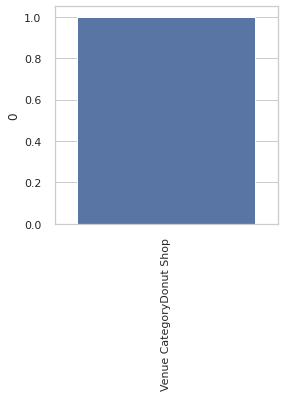

Cluster 1
There are 116 neighborhoods in this cluster


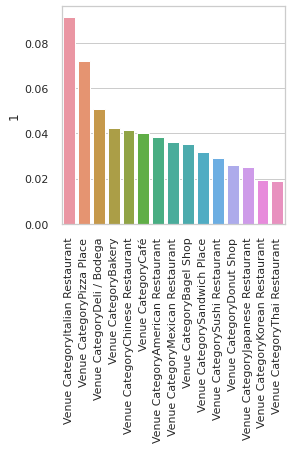

Cluster 2
There are 81 neighborhoods in this cluster


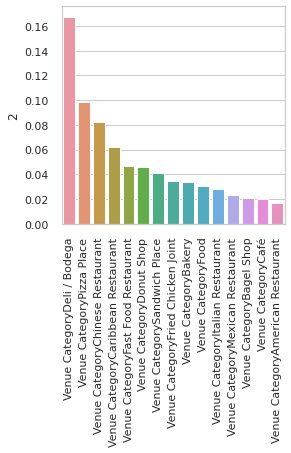

In [111]:
for i in range(3):
    print('Cluster '+str(i))
    print('There are {} neighborhoods in this cluster'.format(ny_merged[ny_merged['Label']==i].shape[0]))
    plt.figure(figsize = (4,4))
    plot_bar(ny_clusters,i)
    plt.show()

### Chicago

In [106]:
chicago_clusters = pd.merge(chicago_grouped, chicago_merged[['Neighborhood', 'Label']], left_on='Neighborhood', right_on='Neighborhood',how='inner')
chicago_clusters = chicago_clusters.iloc[:,1:].groupby('Label').mean().transpose()
chicago_clusters.head()

Label,0.0,1.0,2.0,3.0
Venue CategoryAfghan Restaurant,0.000142,0.000000,0.0,0.000000
Venue CategoryAfrican Restaurant,0.001341,0.000543,0.0,0.005331
Venue CategoryAmerican Restaurant,0.050290,0.048912,0.0,0.057445
Venue CategoryArepa Restaurant,0.000504,0.000000,0.0,0.000000
Venue CategoryArgentinian Restaurant,0.002307,0.000329,0.0,0.000000


Cluster 0
There are 119 neighborhoods in this cluster


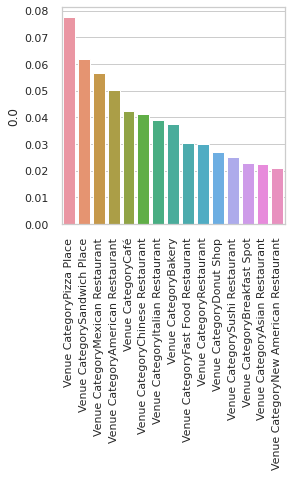

Cluster 1
There are 46 neighborhoods in this cluster


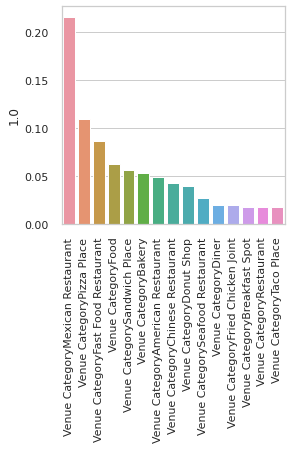

Cluster 2
There are 2 neighborhoods in this cluster


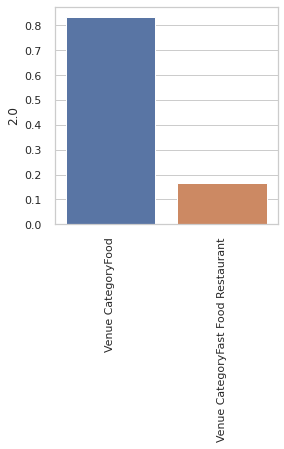

Cluster 3
There are 62 neighborhoods in this cluster


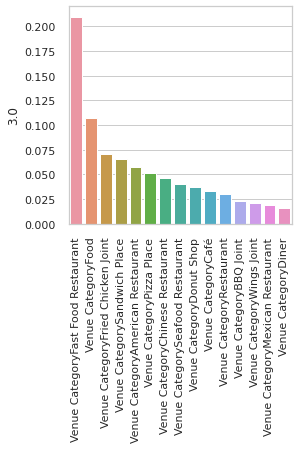

In [108]:
for i in range(4):
    print('Cluster '+str(i))
    print('There are {} neighborhoods in this cluster'.format(chicago_merged[chicago_merged['Label']==i].shape[0]))
    plt.figure(figsize = (4,4))
    plot_bar(chicago_clusters,i)
    plt.show()